In [1]:
import sqlite3
from ossapi import Ossapi
from time import strftime, localtime
import pandas as pd
from gensim.test.utils import datapath
from gensim import utils
import gensim
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

import numpy as np
import sys

sys.path.insert(0, '../') # Add parent directory because data is in parent directory

In [2]:
df = pd.read_parquet('../data/recent_sentences_std2.parquet', engine='pyarrow')
sentences = df['sentences'].tolist()
sentences = [list(sentence) for sentence in sentences]

In [3]:
class MonitorCallback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(
        self, model
    ):  # word2vec accumulates loss, so we need to subtract the previous loss
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print("Loss after epoch {}: {}".format(self.epoch, loss))
        else:
            print(
                "Loss after epoch {}: {}".format(
                    self.epoch, loss - self.loss_previous_step
                )
            )
        self.epoch += 1
        self.loss_previous_step = loss

model = gensim.models.Word2Vec(
    sentences=sentences,
    vector_size=15,
    epochs=100,
    window=20,
    min_count=2,  
    workers=16,
    sg=0,
    hs=0, 
    negative=20,
    ns_exponent=1, 
    compute_loss=True,
    callbacks=[MonitorCallback()],
)

# loss = model.get_latest_training_loss()

Loss after epoch 0: 58682.45703125
Loss after epoch 1: 58029.92578125
Loss after epoch 2: 49196.8828125
Loss after epoch 3: 30749.5625
Loss after epoch 4: 23525.40625
Loss after epoch 5: 21411.0
Loss after epoch 6: 20443.671875
Loss after epoch 7: 19985.8125
Loss after epoch 8: 19580.71875
Loss after epoch 9: 19313.125
Loss after epoch 10: 19111.28125
Loss after epoch 11: 18909.625
Loss after epoch 12: 18742.53125
Loss after epoch 13: 18528.125
Loss after epoch 14: 18322.0
Loss after epoch 15: 18198.5
Loss after epoch 16: 18008.625
Loss after epoch 17: 17826.59375
Loss after epoch 18: 17628.125
Loss after epoch 19: 17484.1875
Loss after epoch 20: 17331.78125
Loss after epoch 21: 17088.625
Loss after epoch 22: 16821.9375
Loss after epoch 23: 16599.375
Loss after epoch 24: 16404.75
Loss after epoch 25: 16122.6875
Loss after epoch 26: 15916.75
Loss after epoch 27: 15720.0
Loss after epoch 28: 15487.0
Loss after epoch 29: 15278.4375
Loss after epoch 30: 15021.5625
Loss after epoch 31: 1485

In [4]:
model.save('recent_word2vec_1.model')

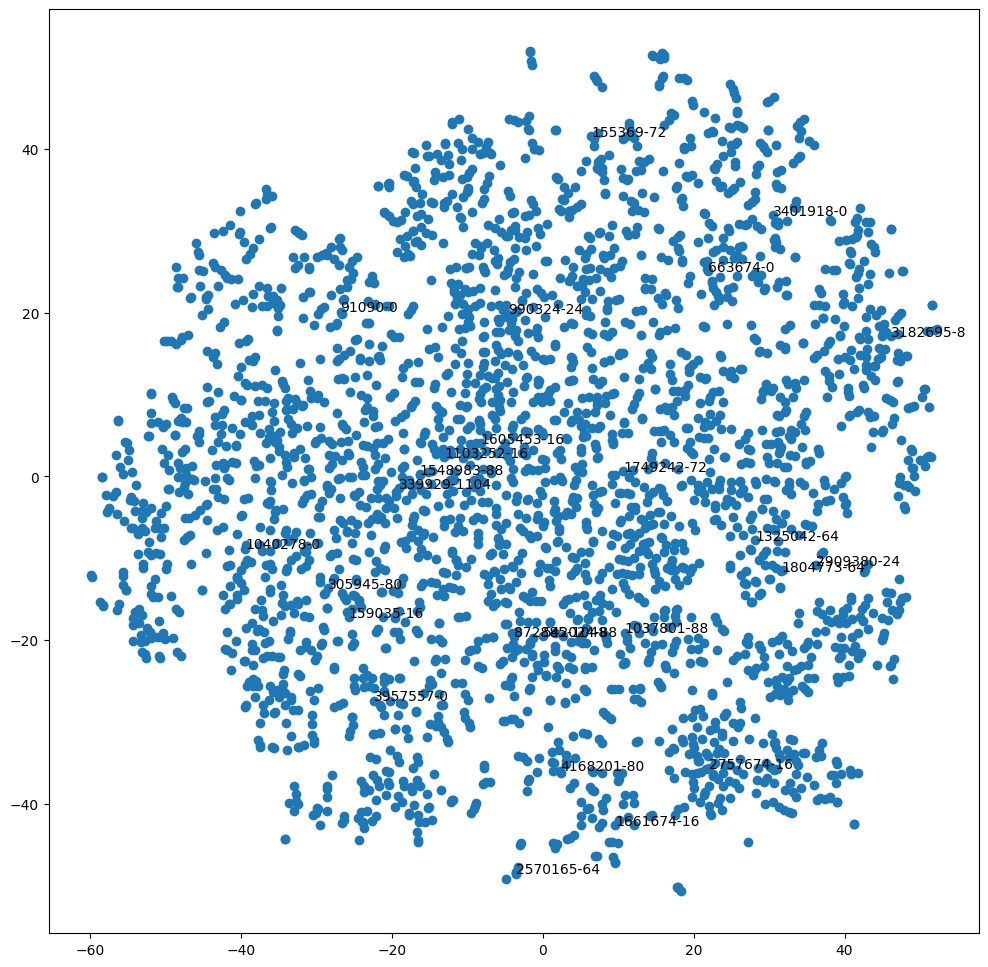

In [16]:
from sklearn.decomposition import IncrementalPCA  # inital reduction
from sklearn.manifold import TSNE  # final reduction
import numpy as np
import random
import matplotlib.pyplot as plt
import random
    
def reduce_dimensions(model):
    num_dimensions = 2
    
    # Limit points for performance
    n_points = 3000
    vectors_sub, labels_sub = zip(*random.sample(list(zip(model.wv.vectors, model.wv.index_to_key)), n_points))
    
    vectors = np.asarray(vectors_sub)
    labels = np.asarray(labels_sub)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_matplotlib(x_vals, y_vals, labels):
    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    # Label randomly subsampled 25 data points
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

x_vals, y_vals, labels = reduce_dimensions(model)
plot_with_matplotlib(x_vals, y_vals, labels)

In [15]:
# # word2vec_model = model
# # else:
#     # word2vec_model = gensim.models.Word2Vec.load("word2vec-pp/word2vec-pp")
# model = gensim.models.Word2Vec.load("w2v_model/w2v_model")
# model.wv.index_to_key[10000:20000]
word2vec_model = model
NN = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(word2vec_model.wv.vectors)

In [16]:
import sys
sys.path.insert(0, "../")
from data.classes import Score

OSU_CLIENT_ID = os.environ.get("OSU_CLIENT_ID")
OSU_CLIENT_SECRET = os.environ.get("OSU_CLIENT_SECRET")
user_id = '28956125'

api = Ossapi(OSU_CLIENT_ID, OSU_CLIENT_SECRET)
top_scores = api.user_scores(user_id, type="best", mode="osu", limit=100)

top_scores = [Score(score) for score in top_scores]
top_scores.sort(key=lambda x: x.pp, reverse=True)

# top_scores = [
#     str(score.beatmap_id) + "-" + str(score.mods) for score in top_scores # Limit to top 50
# ]

top_scores = ['1872812-0']
top_scores_vec = [
    score for score in top_scores if score in word2vec_model.wv.index_to_key
]
top_scores_vec = [word2vec_model.wv[score] for score in top_scores_vec]

neighbor = NN.kneighbors([np.mean(top_scores_vec, axis=0)])

In [17]:
# Get the top 5 beatmaps
beatmaps = [model.wv.index_to_key[i] for i in neighbor[1][0]]
beatmaps = [beatmap for beatmap in beatmaps if beatmap not in top_scores]

beatmaps

['845391-0',
 '2477065-0',
 '1637465-0',
 '1750943-0',
 '620789-0',
 '3018109-0',
 '635679-0',
 '1093605-0',
 '370440-0',
 '442170-0',
 '1557471-0',
 '1744286-0',
 '771858-0',
 '1045757-0',
 '931860-0',
 '386728-0',
 '2615748-0',
 '1188172-0',
 '1959500-0',
 '1502678-0',
 '2023961-0',
 '1972802-0',
 '655300-0',
 '2012740-0',
 '855536-0',
 '2077120-0',
 '2333933-0',
 '1868547-0',
 '2826252-0',
 '2357806-0',
 '767774-0',
 '221777-0',
 '2619918-0',
 '589969-0',
 '381928-0',
 '1863228-0',
 '3211514-0',
 '3385965-0',
 '209276-0',
 '2403266-0',
 '693195-0',
 '2779000-0',
 '2920787-0',
 '2015472-0',
 '2309955-0',
 '720590-0',
 '1601387-0',
 '1432512-0',
 '793845-0']